In [2]:

import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor
from scipy.stats import boxcox
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, RegressorMixin

from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.datasets.danish_data import load

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [4]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

## ARDL


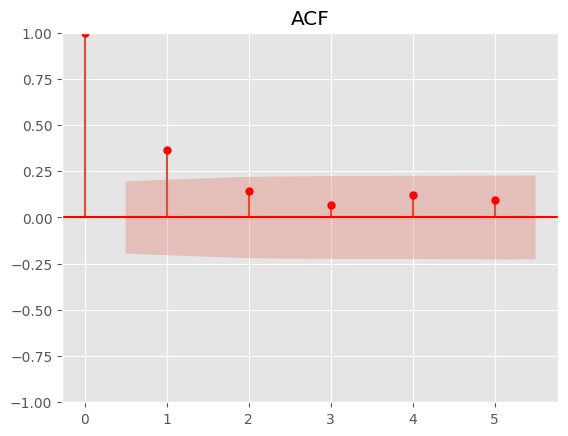

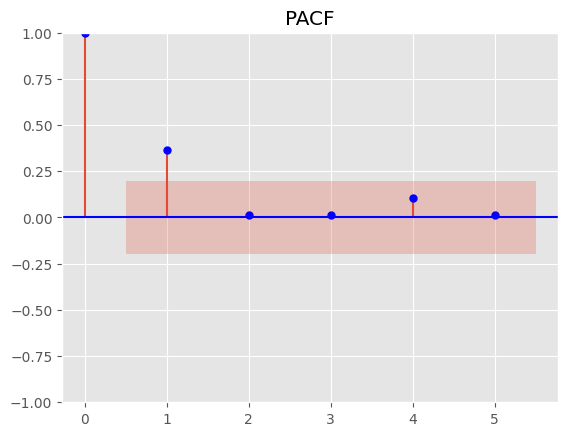

In [5]:
plot_acf(y_train, lags=5, color='r', title='ACF');
plot_pacf(y_train, lags=5, color='b', title='PACF');

In [18]:
res = ARDL(
    y_train, 
    2, 
    X_train,
    {'unemp': 1,
     'fm_price_exp': 1,
     'fm_credit_cond': 1,
     'Brent': 0, 
     'MIACR': 0,
     'obligates': 1,
     'M2': 0,
     'paid_services': 0,
     'money_income': 0,
     'trade_turnover': 0,
     'debt_firms': 0,
     'PCA_1': 0,
     'PCA_2': 0,
     'PCA_3': 0,
     'PCA_4': 1,
     'PCA_5': 0,
     'PCA_6': 0,
     'outlier_12': 0,
     'outlier_98': 1}, 
    trend="c"
).fit()
print(res.summary())

                                                     ARDL Model Results                                                     
Dep. Variable:                                                            inflation   No. Observations:                  100
Model:             ARDL(2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1)   Log Likelihood                 468.959
Method:                                                             Conditional MLE   S.D. of innovations              0.002
Date:                                                              Fri, 02 May 2025   AIC                           -879.918
Time:                                                                      20:28:08   BIC                           -804.954
Sample:                                                                           2   HQIC                          -849.597
                                                                                100                                         


In [19]:
sel_res_bic = ardl_select_order(
    y_train, 2, X_train, 1, ic="bic", trend="c"
)
sel_res_bic.model.ardl_order

: 

In [ ]:
ardl_res = sel_res_bic.model.fit()
print(ardl_res.summary())

                                   ARDL Model Results                                   
Dep. Variable:                        inflation   No. Observations:                  100
Model:             ARDL(1, 1, 0, 0, 0, 0, 0, 1)   Log Likelihood                  51.381
Method:                         Conditional MLE   S.D. of innovations              0.144
Date:                          Sun, 27 Apr 2025   AIC                            -78.761
Time:                                  21:34:33   BIC                            -47.620
Sample:                                       1   HQIC                           -66.161
                                            100                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.7204      1.790      3.195      0.002       2.163       9.278
inflation.L1      0.5068      0.052      9

In [ ]:
sel_res_aic = ardl_select_order(
    y_train, 2, X_train, 1, ic="aic", trend="c"
)
sel_res_aic.model.ardl_order

(1, 1, 1, 0, 0, 0, 1, 1, 1)

In [ ]:
ardl_res = sel_res_aic.model.fit()
print(ardl_res.summary())

                                     ARDL Model Results                                    
Dep. Variable:                           inflation   No. Observations:                  100
Model:             ARDL(1, 1, 1, 0, 0, 0, 1, 1, 1)   Log Likelihood                  57.566
Method:                            Conditional MLE   S.D. of innovations              0.135
Date:                             Sun, 27 Apr 2025   AIC                            -83.132
Time:                                     21:35:04   BIC                            -41.610
Sample:                                          1   HQIC                           -66.332
                                               100                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.3192      4.123      3.716      0.000       7.121      23.518
inflation

## XGBoost


/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_91728/2600989725.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_train['ds'] = pd.date_range(
/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_91728/2600989725.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_test['ds'] = pd.date_range(end='2023-08-31', freq='M', periods=len(y_test))


Mean Squared Error: 0.0000
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


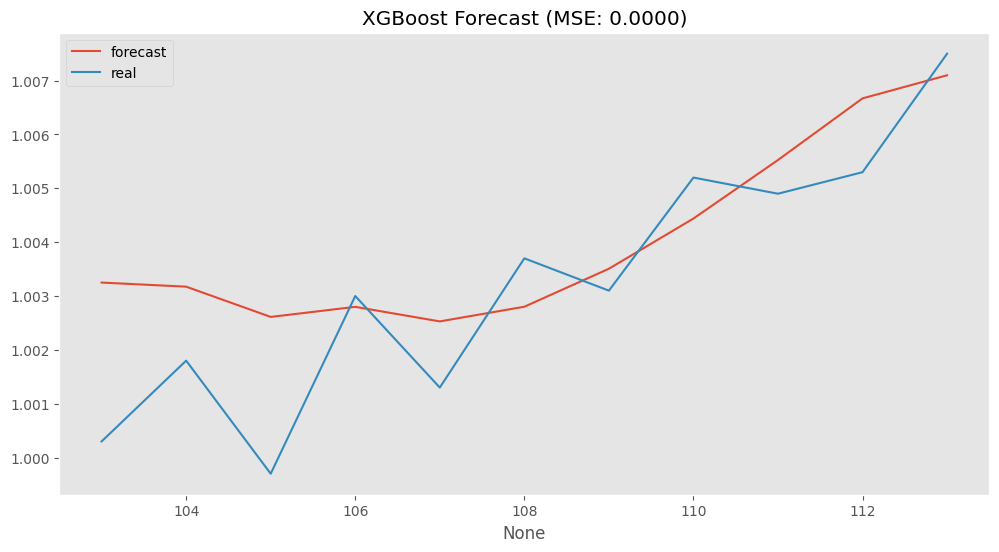

In [6]:

def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    """
    Создает временные признаки для модели:
    - Лаги (авторегрессионная компонента)
    - Скользящие статистики
    - Временные фичи из даты
    """
    df = df.copy()

    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)

    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month

    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='M', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='M', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)

# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_91728/1361121226.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[98] = (y_train[97] + y_train[99]) / 2


Mean Squared Error: 0.0000
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


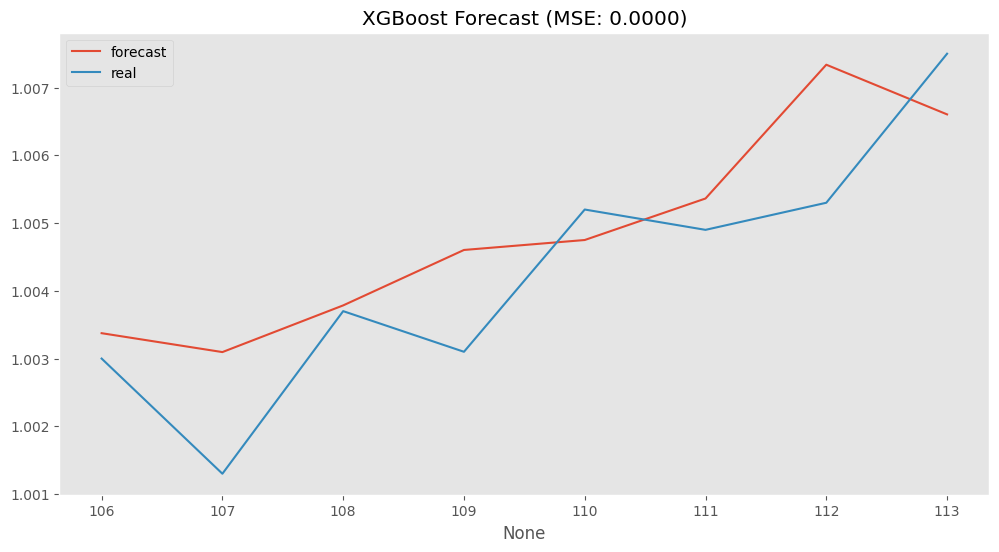

In [7]:

def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    """
    Создает временные признаки для модели:
    - Лаги (авторегрессионная компонента)
    - Скользящие статистики
    - Временные фичи из даты
    """
    df = df.copy()

    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(window=window_size).std().shift(1)

    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month

    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()



# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2

# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)

# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()